# Economic news article Text Classification

In [38]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd # to work with csv files

# matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

# import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# pre-processing of text
import string
import re

# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score

# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

# import time function from time module to track the training duration
from time import time

In [ ]:
!wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
!ls -lah DATAPATH


--2025-06-03 16:07:54--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12383529 (12M) [application/octet-stream]
Saving to: ‘DATAPATH/Full-Economic-News-DFE-839861.csv’

Full-Economic-News- 100%[===================>]  11.81M  1.35MB/s    in 11s     

2025-06-03 16:08:06 (1.09 MB/s) - ‘DATAPATH/Full-Economic-News-DFE-839861.csv’ saved [12383529/12383529]

total 12M
drwxr-xr-x 2 fahad fahad 4.0K Jun  3 16:07 .
drwxr-xr-x 3 fahad fahad 4.0K Jun  3 16:07 ..
-rw-r--r-- 1 fahad fahad  12M Jun  3 16:08 Full-Economic-News-DFE-839861.csv


In [26]:
our_data = pd.read_csv("DATAPATH/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )
shape = our_data.shape
shape

(8000, 15)

In [27]:
# Class distribution in dataset
def class_distribution():
    return display(our_data["relevance"].value_counts() / our_data.shape[0] * 100)

class_distribution()

relevance
no          82.1375
yes         17.7500
not sure     0.1125
Name: count, dtype: float64

There is an imbalance in the data with not relevant being 82% in the dataset. That is, most of the articles are not relevant to US Economy, which makes sense in a real-world scenario, as news articles discuss various topics. We should keep this class imbalance mind when interpreting the classifier performance later. Let us first convert the class labels into binary outcome variables for convenience. 1 for Yes (relevant), and 0 for No (not relevant), and ignore "Not sure"

In [29]:
# removing the row where relavance is 'not sure'
# our_data.head()
our_data = our_data[our_data.relevance != "not sure"]
our_data.shape

(7991, 15)

In [19]:
# Convert label to a numerical variable
class_distribution()
our_data.shape

relevance
no     82.230009
yes    17.769991
Name: count, dtype: float64

(7991, 15)

In [30]:
# converting label to numeric data
# relavent is 1, non-relavent is 0
our_data['relevance'] = our_data.relevance.map({ 'yes': 1, 'no': 0 })

# Take only two column we need
our_data = our_data[["text", "relevance"]]
our_data.head()

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


## 2. Text Preprocessing

Typical steps involve tokenization, lower casing, removing, stop words, punctuation markers etc, and vectorization. Other processes such as stemming/lemmatization can also be performed. Here, we are performing the following steps: removing br tags, punctuation, numbers, and stopwords. While we are using sklearn's list of stopwords, there are several other stop word lists (e.g., from NLTK) or sometimes, custom stopword lists are needed depending on the task.



In [22]:
our_data.head()

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,NaN
1,The Wall Street Journal Online</br></br>The Mo...,NaN
2,WASHINGTON -- In an effort to achieve banking ...,NaN
3,The statistics on the enormous costs of employ...,NaN
4,NEW YORK -- Indecision marked the dollar's ton...,NaN


In [47]:
stopwords = ENGLISH_STOP_WORDS

def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    # remove punctuation and numbers
    return doc

In [48]:
our_data['text'] = our_data['text'].apply(clean)
our_data.head()

,text,relevance
0,NEW YORK Yields certificates deposit offered m...,1
1,The Wall Street Journal Online The Morning Bri...,0
2,WASHINGTON In effort achieve banking reform Se...,0
3,The statistics enormous costs employee drug ab...,0
4,NEW YORK Indecision marked dollars tone trader...,1


## Section 3: Modeling

Now we are ready for the modelling. We are going to use algorithms from sklearn package. We will go through the following steps:

1 Split the data into training and test sets (75% train, 25% test)

2 Extract features from the training data using CountVectorizer, which is a bag of words feature 
implementation. We will use the pre-processing function above in conjunction with Count Vectorizer

3 Transform the test data into the same feature vector as the training data.

4 Train the classifier

5 Evaluate the classifier

In [50]:
import sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

# Step 1: train-test split
X = our_data.text # the column text contains textual data to extract features from
y = our_data.relevance # this is the column we are learning to predict. 
print(X.shape, y.shape)

# split X and y into training and testing sets. By default, it splits 75% training and 25% test
# random_state=1 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7991,) (7991,)
(5993,) (5993,)
(1998,) (1998,)


In [52]:
# Step 2-3: Preprocess and Vectorize train and test data
vect = CountVectorizer(preprocessor=clean) # instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train) # use it to extract features from training data
X_train_dtm

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 611297 stored elements and shape (5993, 49753)>

In [53]:
# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)

# print shapes of train and test data
print(X_train_dtm.shape, X_test_dtm.shape)

# i.e., the dimension of our feature vector is 49753!

(5993, 49753) (1998, 49753)


In [56]:
# Step 3: Train the classifier and predict for test data
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model

# train the model
%time nb.fit(X_train_dtm, y_train) # (timing it with an IPython "magic command")

CPU times: user 29.2 ms, sys: 0 ns, total: 29.2 ms
Wall time: 23.9 ms


MultinomialNB()

In [58]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm) 
print(y_pred_class)

[0 0 1 ... 0 0 0]


In [63]:
# Step 4: Evaluate the classifier using various measures

# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

In [66]:
  
# Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

# calculate AUC: Area under the curve(AUC) gives idea about the model efficiency:
# Further information: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))

Accuracy:  0.7822822822822822
ROC_AOC_Score:  0.7251117679464362


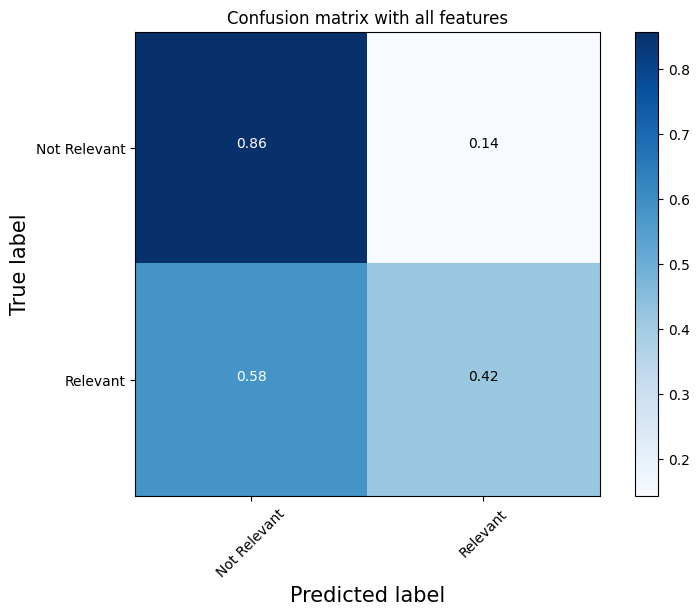

In [67]:
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with all features')



**Experiment 1**: At this point, we can notice that the classifier is doing poorly with identifying relevant articles, while it is doing well with non-relevant ones. Our large feature vector could be creating a lot of noise in the form of very rarely occurring features that are not useful for learning. Let us change the count vectorizer to take a certain number of features as maximum.

In [68]:
# Train the model again by limiting the features
vect = CountVectorizer(preprocessor=clean, max_features=5000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3

X_test_dtm = vect.transform(X_test)

nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model

%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")

CPU times: user 9.03 ms, sys: 0 ns, total: 9.03 ms
Wall time: 8.29 ms


MultinomialNB()

Accuracy:  0.6876876876876877


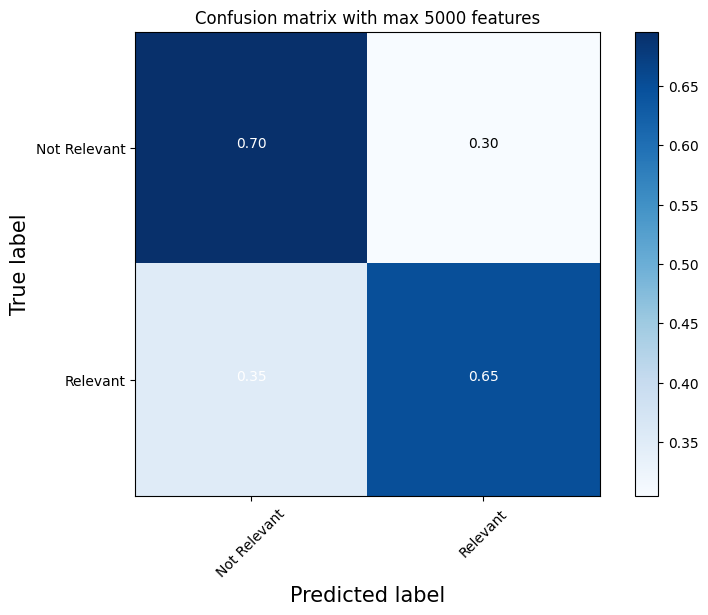

In [69]:
# Evaluate again
y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm

print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with max 5000 features')

**Experiment 2 Conclusion**: Clearly, the performance on relevance classification got better even though the overall accuracy fell by 10%. Let us try another classification algorithm and see if the performance changes. For this experiment, we have considered logistic regression, with class_weight attribute as "balanced", to address the problem of class imbalance in this dataset.

## Experiment with Logistic Regression

Accuracy:  0.7367367367367368
AUC:  0.7251117679464362


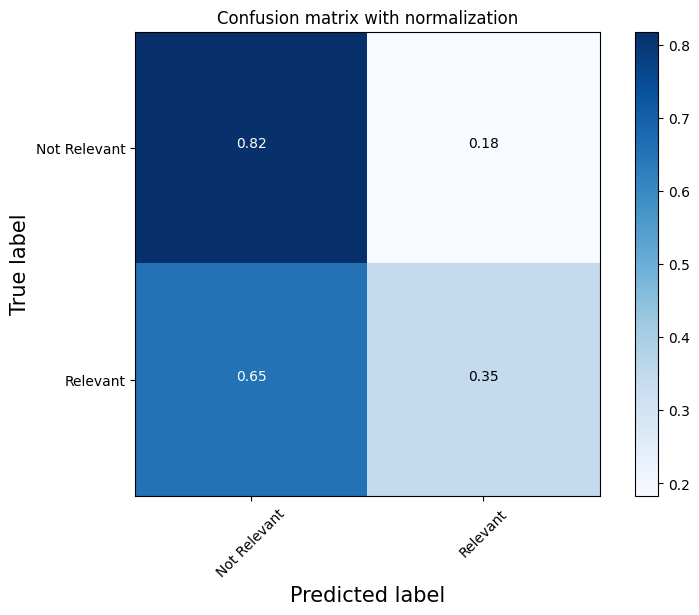

In [70]:
from sklearn.linear_model import LogisticRegression # import

logreg = LogisticRegression(class_weight="balanced") # instantiate a logistic regression model
logreg.fit(X_train_dtm, y_train) # fit the model with training data

# Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')

# Experiment with SVM

Accuracy:  0.6836836836836837
AUC:  0.7251117679464362


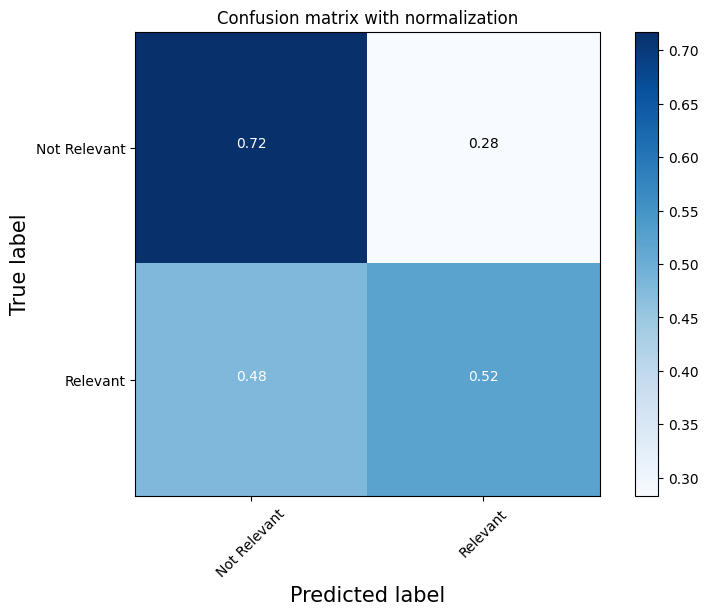

In [71]:
from sklearn.svm import LinearSVC

vect = CountVectorizer(preprocessor=clean, max_features=1000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced') # instantiate a logistic regression model
classifier.fit(X_train_dtm, y_train) # fit the model with training data

# Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Not Relevant','Relevant'],normalize=True,
                      title='Confusion matrix with normalization')